In [14]:
!pip3 install xgboost
!pip3 install pandas

# Read In Data
import pandas as pd
import numpy as np

goalies_df = pd.read_csv('Goalies.csv', on_bad_lines='skip')
teams_df = pd.read_csv('Teams.csv')

# Merge datasets
merged_df = pd.merge(
    teams_df,
    goalies_df,
    on=['year', 'tmID'],
    how='inner'
)

# 1. Drop unnecessary columns
columns_to_drop = ['lgID_y', 'confID', 'divID', 'franchID', 'name', 
                  'PostGP', 'PostMin', 'PostW', 'PostL', 'PostT', 'PostENG', 
                  'PostSHO', 'PostGA', 'PostSA', 'playoff', 'rank', 'ENG', 
                  'lgID_x', 'GA_y', 'W_x', 'L_x', 'T', 'OTL', 'W_y', 'L_y', 
                  'T/OL', 'SoW', 'SoL']
cleaned_df = merged_df.drop(columns=columns_to_drop)

# 2. Rename columns for clarity
cleaned_df = cleaned_df.rename(columns={'GA_x': 'GA'})

# 3. Group by team and year to get team-level statistics
team_stats = cleaned_df.groupby(['year', 'tmID']).agg({
    'G': 'first',          # Games played by team
    'Pts': 'first',        # Team points
    'GF': 'first',         # Goals for
    'GA': 'first',         # Goals against
    'GP': 'sum',           # Total games played by goalies
    'Min': 'sum',          # Total minutes by goalies
    'SHO': 'sum',          # Total shutouts
    'SA': 'sum',           # Total shots against
    'PIM': 'first',        # Penalties in minutes
    'PPG': 'first',        # Power play goals
    'PPC': 'first',        # Power play chances
    'PKG': 'first',        # Penalty kill goals against
    'PKC': 'first'         # Penalty kill chances
}).reset_index()

# 4. Calculate additional metrics
team_stats['SavePercentage'] = (team_stats['SA'] - team_stats['GA']) / team_stats['SA']
team_stats['GoalsAgainstAvg'] = (team_stats['GA'] * 60) / team_stats['Min']

# 5. Handle missing/infinite values
team_stats = team_stats.replace([np.inf, -np.inf], np.nan)

# 6. Display summary statistics and check for missing values
print("\nDataset Shape:", team_stats.shape)
print("\nMissing Values:")
print(team_stats.isnull().sum())
print("\nSummary Statistics:")
print(team_stats.describe())

# Optional: Save cleaned dataset
# team_stats.to_csv('cleaned_hockey_stats.csv', index=False)

# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Prepare features and target
features_to_drop = ['Pts', 'year', 'tmID']
X = team_stats.drop(columns=features_to_drop)
y = team_stats['Pts']

# Clean NaN and infinite values before modeling
print(f"\nOriginal number of rows: {len(X)}")

# 1. Remove rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan)
mask = ~X.isna().any(axis=1)  # Create mask of rows without NaN
X = X[mask]
y = y[mask]

print(f"Number of rows after removing NaN/infinite values: {len(X)}")
print(f"Removed {len(team_stats) - len(X)} rows")

# Now proceed with the model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.

Dataset Shape: (1490, 17)

Missing Values:
year                 0
tmID                 0
G                    0
Pts                  0
GF                   0
GA                   0
GP                   0
Min                  0
SHO                  0
SA                   0
PIM                110
PPG                418
PPC                419
PKG                418
PKC                419
SavePercentage     686
GoalsAgainstAvg      1
dtype: int64

Summary Statistics:
              year            G          Pts           GF           GA  \
count  1490.000000  1490.000000  1490.000000  1490.000000  1490.000000   
mean   1973.818121    69.275168    70.884564   218.649664   218.619463   
std      28.527716   

In [15]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Import Linear Regression
from sklearn.linear_model import LinearRegression

# Train both models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
lr_model = LinearRegression()

rf_model.fit(X_train_scaled, y_train)
lr_model.fit(X_train_scaled, y_train)

# Make predictions for both models
rf_pred = rf_model.predict(X_test_scaled)
lr_pred = lr_model.predict(X_test_scaled)

# Calculate metrics for both models
rf_mse = mean_squared_error(y_test, rf_pred)
lr_mse = mean_squared_error(y_test, lr_pred)

rf_r2 = r2_score(y_test, rf_pred)
lr_r2 = r2_score(y_test, lr_pred)

print("\nRandom Forest Performance:")
print(f"Root Mean Squared Error: {np.sqrt(rf_mse):.2f} points")
print(f"R-squared Score: {rf_r2:.3f}")

print("\nLinear Regression Performance:")
print(f"Root Mean Squared Error: {np.sqrt(lr_mse):.2f} points")
print(f"R-squared Score: {lr_r2:.3f}")


Random Forest Performance:
Root Mean Squared Error: 5.98 points
R-squared Score: 0.892

Linear Regression Performance:
Root Mean Squared Error: 5.41 points
R-squared Score: 0.912


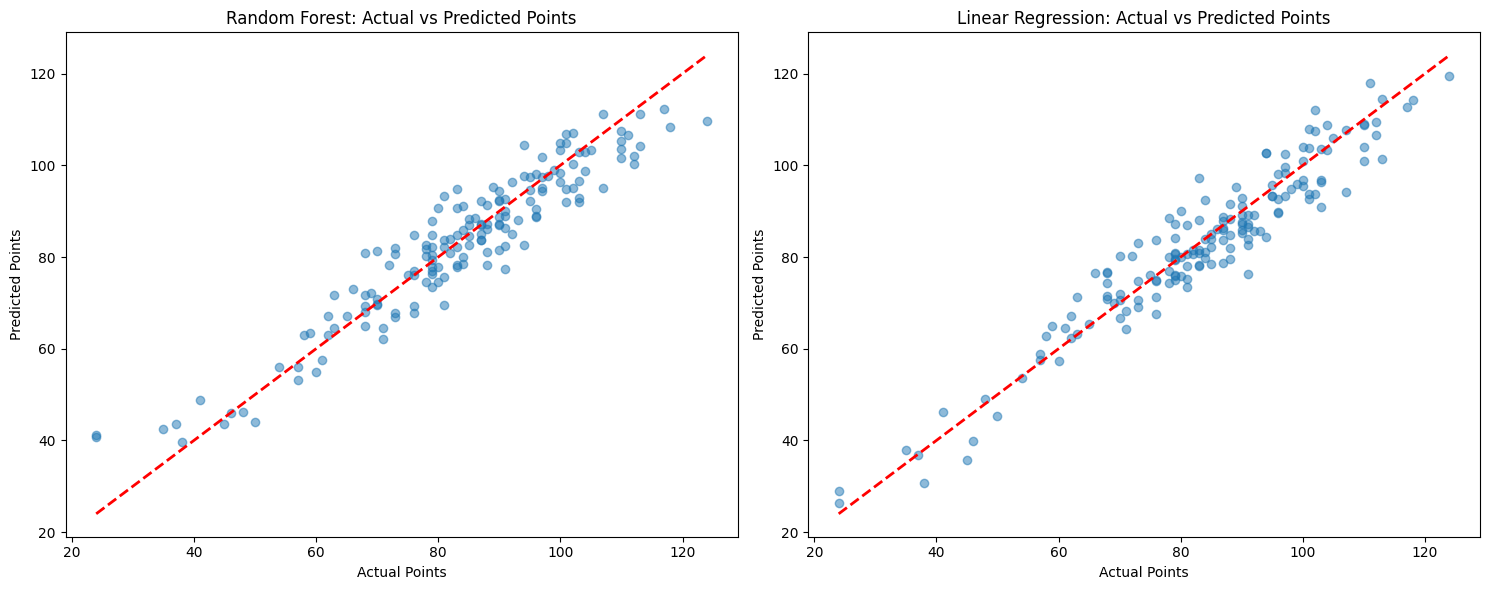


Top 10 Most Important Features (Linear Regression):
            feature  coefficient  abs_coefficient
4               Min    15.390294        15.390294
1                GF    13.912975        13.912975
2                GA   -13.799164        13.799164
12   SavePercentage     8.196551         8.196551
13  GoalsAgainstAvg     6.565341         6.565341
6                SA    -6.104374         6.104374
0                 G    -5.309042         5.309042
7               PIM    -2.776026         2.776026
10              PKG     1.812894         1.812894
8               PPG     1.764267         1.764267

Top 10 Most Important Features:
            feature  importance
1                GF    0.486944
13  GoalsAgainstAvg    0.322972
2                GA    0.098557
12   SavePercentage    0.014134
7               PIM    0.013702
4               Min    0.013113
8               PPG    0.011269
6                SA    0.007903
3                GP    0.007342
9               PPC    0.006765


In [16]:
# Create side-by-side plots
plt.figure(figsize=(15, 6))

# Random Forest plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Random Forest: Actual vs Predicted Points')

# Linear Regression plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, lr_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Linear Regression: Actual vs Predicted Points')

plt.tight_layout()
plt.show()

# Feature importance for Linear Regression
lr_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_
})
lr_importance['abs_coefficient'] = abs(lr_importance['coefficient'])
lr_importance = lr_importance.sort_values('abs_coefficient', ascending=False)

print("\nTop 10 Most Important Features (Linear Regression):")
print(lr_importance.head(10))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

In [17]:
# Optional: Cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print(f"Average CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

# Initialize additional models
xgb_model = XGBRegressor(random_state=42)
svr_model = SVR(kernel='rbf')
gb_model = GradientBoostingRegressor(random_state=42)

# Train additional models
xgb_model.fit(X_train_scaled, y_train)
svr_model.fit(X_train_scaled, y_train)
gb_model.fit(X_train_scaled, y_train)

# Make predictions
xgb_pred = xgb_model.predict(X_test_scaled)
svr_pred = svr_model.predict(X_test_scaled)
gb_pred = gb_model.predict(X_test_scaled)

# Calculate metrics for all models
models = {
    'Random Forest': (rf_pred, rf_model),
    'Linear Regression': (lr_pred, lr_model),
    'SVR': (svr_pred, svr_model),
    'Gradient Boosting': (gb_pred, gb_model)
}

# Create comparison metrics
results = []
for name, (predictions, model) in models.items():
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results.append({
        'Model': name,
        'RMSE': np.sqrt(mse),
        'R2': r2
    })

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

# Visualization of all models
plt.figure(figsize=(15, 10))


# 2. R² scores bar plot
plt.subplot(2, 1, 2)
plt.bar(results_df['Model'], results_df['R2'])
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Model Performance Comparison (R²)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Cross-validation comparison
cv_results = {}
for name, (_, model) in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    cv_results[name] = {
        'Mean': cv_scores.mean(),
        'Std': cv_scores.std()
    }

cv_df = pd.DataFrame(cv_results).T
print("\nCross-validation Results:")
print(cv_df)

# Feature importance comparison (for models that support it)
plt.figure(figsize=(12, 6))
feature_importance_dict = {}

# Get feature importance for supported models
for name, (_, model) in models.items():
    if hasattr(model, 'feature_importances_'):
        feature_importance_dict[name] = model.feature_importances_

# Plot feature importance for each model
for i, (name, importance) in enumerate(feature_importance_dict.items()):
    plt.subplot(1, len(feature_importance_dict), i+1)
    sorted_idx = np.argsort(importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, importance[sorted_idx])
    plt.yticks(pos, X.columns[sorted_idx])
    plt.title(f'{name}\nFeature Importance')

plt.tight_layout()
plt.show()


Cross-validation scores: [0.90333232 0.90687616 0.87492448 0.88512288 0.87035435]
Average CV Score: 0.888 (+/- 0.029)


NameError: name 'XGBRegressor' is not defined